# Linear predictive border padding

In [43]:
import numpy as np
from scipy.signal import lfilter, lfiltic
from spectrum import arburg


def arburg_extrap(signal, extr_length, order=2):
    """ 
    Given a "signal", it concatenates the extrapolation at the end of the signal of length "extr_length"
    _______signal________ + ___extrap___

    The extrapolation is calculated using a 1-D digital filter (filter in MATLAB or scipy.signal.lfilter in Python)
    The parameters for the filter comes from an autoregressive Burg's method (arburg) with order "order"    

    Example:

    signal = np.arange(10)
    print(f" signal: {signal}")
    extrap_forward = arburg_extrap(signal, 3, 2)
    print(f" extrap_forward: {extrap_forward}")
    extrap_backward = arburg_extrap(extrap_forward[::-1], 3, 2)[::-1]
    print(f" extrap_backward: {extrap_backward}")
    """
    a0, _, _ = arburg(signal, order)
    a = np.concatenate(([1], a0)) # add a 1 at the begining of a0 to look like on Matlab

    last_points = signal[-order:] #last points, number of points == order
    last_points = last_points[::-1] # give the "last points" in reverse order, the oldest the first (as lfilter wants the x and y)

    Z = lfiltic(b=1, a=a, y=last_points, x=None) # Initial conditions for the lfilter
    yzi, _ = lfilter(b=1, a=a, x=np.zeros(extr_length), zi=Z)

    extrap = np.concatenate((signal, yzi.real))

    return extrap


def lpbp1D(signalIn, dL, dR, order=2):
    """
    LPBP1D 1D Linear Predictive Border Padding
    
    This function extrapolates linear microphone array data by means of
    designing and applying filters with AR prediction coefficients.
    
    Parameters:
    signalIn : array-like (size N)
        1D input signal
    dL, dR,: int
        Number of samples added before and after the signal
    order : int
        Order of the filter ("number of Fourier peaks")
        
    Returns:
    signalOut : array-like
        Extrapolated signal. 
        1D array resulting of a concatenation of [dL, N, dR] samples
        dN being extrapolated parts.
    """
    
    signal_extr_forw = arburg_extrap(signalIn, extr_length=dR, order=order) # extrapolate forward in time
    signalOut = arburg_extrap(signal_extr_forw[::-1], extr_length=dL, order=order)[::-1] # flip the signal and extrapolate to extrapolate backwards in time
    
    return signalOut


# N = orig_image.shape[1]
# dN = 14

# # image_under = orig_image*mask0
# image_under = orig_image


# y = image_under[0, :]
# extrap_signal = lpbp1D(y, dN, 2)

# x = np.arange(dN, N+dN)
# plt.plot(x, y, linewidth=4, c='b')
# plt.plot(extrap_signal, c='r')
# plt.show()


# Operaciones con imagenes

In [67]:
import numpy as np

def next_power_of_2(n):
    """Return the next power of 2 greater than or equal to n."""
    return 1 if n == 0 else 2**int(np.ceil(np.log2(n)))


class ImageOps:
    """ 
    Lo uso para crear un objeto imagen con un método:
        expand_image() 
            que pueda expandirse en la imagen extrapolada
        recover_image()
            que devuelva la imagen original
        mask_image()
            que devuelva la imagen enmascarada     
    """
    def __init__(self, image_shape, mask, mode="pad", extrap_shape=None) -> None:
        # self.image = image
        self.orig_shape = image_shape
        self.mask = mask
        self.state = "original"
        self.mode = mode

        m0, n0 = image_shape
        # Si extrap_shape es None, usar next_power_of_2 para calcular m y n
        if extrap_shape is None:
            m = next_power_of_2(m0)
            n = next_power_of_2(n0)
        else:
            m, n = extrap_shape

        # Asignar extrap_shape basado en los valores calculados o proporcionados
        self.extrap_shape = (m, n)

        self.up_pad = max((m - m0) // 2, 0)
        self.down_pad = max(m - self.up_pad - m0, 0)
        self.left_pad = max((n - n0) // 2, 0)
        self.right_pad = max(n - self.left_pad - n0, 0)

    def expand_image(self, image):
        """
        Extrapolate an image to the next power of 2 dimensions or specified padding.
        Parameters:
        image (np.array): 2D array to be extrapolated.
        flag_extrap (int): Currently unused. Reserved for future use.

        Returns:
        np.array: Padded 2D array.
        """

        if image.shape == self.extrap_shape:
            return image
        
        elif self.mode == "extrapolate":

            T = image.shape[0]
            M = self.extrap_shape[1]            

            image_ext = np.zeros((T, M))
            for tt in range(T):  # execute linear predictive border padding
                image_ext[tt, :] = lpbp1D(image[tt, :], dL=self.left_pad, dR=self.right_pad, order=2)

            # Pad vertically with 0s
            pad_width = ((self.up_pad, self.down_pad), (0, 0))
            padded_image = np.pad(image_ext, pad_width, mode='constant', constant_values=0)

            self.state = "expanded"

            return padded_image
        
        else:   
            # Padding the 2D array with zeros
            pad_width = ((self.up_pad, self.down_pad), (self.left_pad, self.right_pad))
            padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)

            self.state = "expanded"

            return padded_image
    
        
    def recover_image(self, image):
        """ Take the original image from the extrapolated image """
        if image.shape == self.extrap_shape:
            m, n = self.extrap_shape
            rec_image = image[self.up_pad: m-self.down_pad, self.left_pad:n-self.right_pad]
            self.state = "original"
            return rec_image
        else:
            return image
    

    def get_mask(self, image):
        if image.shape == self.orig_shape:
            return self.mask
        
        # Pad the mask to match the extrapolated image dimensions
        if self.mask.ndim == 1:
            pad_width = (self.left_pad, self.right_pad)
        elif self.mask.ndim == 2:
            pad_width = ((0, 0), (self.left_pad, self.right_pad))
        else:
            raise ValueError("Unsupported mask dimension: {}".format(self.mask.ndim))

        if self.mode == "extrapolate":
            pad_values = 1
        else:
            pad_values = 0
        
        padded_mask = np.pad(self.mask, pad_width, mode='constant', constant_values=pad_values)
        return padded_mask

        
    def mask_image(self, image):
        return self.get_mask(image) * image
            

orig_image = np.ceil(10*np.random.rand(5,5))
mask = np.ones(5)
mask[3] = 0

Sk = np.ones((8,8,12))
extr_size = Sk.shape[:2]

imOps = ImageOps(orig_image.shape, mask, extrap_shape=(8,10), mode="extrapolate") 
# imOps = ImageOps(orig_image.shape, mask, extrap_shape=(0,10), mode="pad") 
im_ex = imOps.expand_image(orig_image)

mask_exp = imOps.get_mask(im_ex)
mask_ori = imOps.get_mask(orig_image)

print(f"orig_image")
print(orig_image)

print("extrapolated image")
print(im_ex)


print("mask extrap")
print(mask_exp)

print("mask")
print(mask_ori)




orig_image
[[ 8.  9.  7.  9. 10.]
 [ 5. 10.  8.  8.  8.]
 [ 4.  6.  9.  5.  9.]
 [ 2. 10.  2.  4.  3.]
 [ 7.  6.  8.  8.  5.]]
extrapolated image
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 8.18701011  8.42562563  8.          9.          7.          9.
  10.          9.46462654  9.60958453  9.45396646]
 [ 6.08975975  7.7670754   5.         10.          8.          8.
   8.          7.80612808  7.72253092  7.58090753]
 [ 4.25449705  5.33280735  4.          6.          9.          5.
   9.          6.0917299   7.65150503  6.33559504]
 [ 2.62192739  7.307213    2.         10.          2.          4.
   3.          3.11312342  2.47572918  2.44588111]
 [ 6.58964963  6.63582461  7.          6.          8.          8.
   5.          5.36516081  5.14801848  5.03608782]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.      

# Transformaciones

In [68]:

def ffst(image, Sk_func_dict):
    """
    image (M,N)
    Sk_func_dict (M,N,d) (Fourier Space)
    alpha (coefs in physical space of Sk functions)
    """

    F2d_im = np.fft.fft2(image) 
    F2d_im = np.fft.fftshift(F2d_im) # order coefs from negative to positive in axes=(0,1)

    # Proyection in Fourier space for all functions in dictionary
    Fproyection = Sk_func_dict * F2d_im[:, :, np.newaxis]
    Fproyection = np.fft.ifftshift(Fproyection, axes=(0,1))  # no ifftshift in 3rd axis
    
    # alpha contains the projection of the image in each decomposition/scale in physical space
    alpha = np.fft.ifft2(Fproyection, axes=(0, 1)).real  # by default, fft2 operates in the last 2 axes

    return alpha


def iffst(alpha, Sk_func_dict):
    """
    alpha (M,N, d): coefs in phys space of the Sk functions
    Sk_func_dict (M,N,d): Functions/kernels in dictionary
    rec_image: reconstruction of the image in physical space
    """

    # Change alpha to Fourier space
    F_alpha = np.fft.fft2(alpha, axes=(0,1))
    F_alpha = np.fft.fftshift(F_alpha, axes=(0,1))

    # Multiply coeficients by the functions in dictionary (in Fourier)
    sum_alpha = np.sum( F_alpha*Sk_func_dict , axis=2) # sum up decompositions
    sum_alpha = np.fft.ifftshift(sum_alpha) # axis=(0,1) since axis=2 has been reduced with the sum
    
    # Change from Fourier to physical space
    rec_image = np.fft.ifft2(sum_alpha).real # recover RIR image
 
    return rec_image


def wthresh(x, thresh):
    return np.sign(x) * np.maximum(np.abs(x) - thresh, 0)


def common_operations(image, mask, Sk, alpha, threshold):
    # Recupera la imagen de las coeficientes
    rec_image = mask * iffst(alpha, Sk)
    # Calcula la diferencia entre la imagen original y la recuperada
    diff_image = mask * (image - rec_image)
    # Proyecta la diferencia en el espacio de Fourier
    diff_alpha = ffst(diff_image, Sk)

    # Actualiza la señal y aplica el umbral
    signal = alpha + diff_alpha
    # thresh = beta * np.max(np.abs(alpha))

    # Aplica el umbral suave a la señal
    alpha_new = wthresh(signal, threshold)

    # Calcula las métricas de esparcidad y residuo
    eta = np.linalg.norm(alpha_new.ravel(), 1)       # ||alpha_new||_1

    rec_image_new = mask * iffst(alpha_new, Sk)
    diff_image_new = mask * (image - rec_image_new)
    rho = np.linalg.norm(diff_image_new.ravel(), 2)  # || diff_image ||_2

    return alpha_new, eta, rho




In [69]:
beta_set = np.logspace(-2.5, -1, 50)

def computePareto(image, mask, Sk, beta_set):
    from scipy.interpolate import splrep, splev, splder
    import matplotlib.pyplot as plt


    # preallocate:
    # eta = np.zeros((len(beta_set), 1))  # sparsity norm
    # rho = np.zeros((len(beta_set), 1))  # residual norm
    eta = np.zeros_like(beta_set)  # sparsity norm
    rho = np.zeros_like(beta_set)  # residual norm

    image = mask*image
    alpha0 = ffst(image, Sk)  # initialize solution vector
    norm_inf_alpha0 = np.linalg.norm(alpha0.ravel(), np.inf)

    for bb, beta in enumerate(beta_set):
        threshold = beta * norm_inf_alpha0
        _, eta[bb], rho[bb] = common_operations(image, mask, Sk, alpha0, threshold)
        print(f'Pareto iteration {bb+1}/{len(beta_set)}.')

    # Interpolación spline cúbica para eta y rho
    eta_sp = splrep(beta_set, np.log(eta))
    rho_sp = splrep(beta_set, np.log(rho))

    # Derivadas primera y segunda de eta y rho
    eta_prime1 = splev(beta_set, splder(eta_sp, 1)) # eta'
    eta_prime2 = splev(beta_set, splder(eta_sp, 2)) # eta''
    rho_prime1 = splev(beta_set, splder(rho_sp, 1)) # rho'
    rho_prime2 = splev(beta_set, splder(rho_sp, 2)) # rho''

    # Cálculo de la curva J
    Jcurve = (rho_prime2 * eta_prime1 - rho_prime1 * eta_prime2) / (rho_prime1**2 + eta_prime1**2)**1.5

    # Encontrar el beta óptimo
    idx_max_curv = np.argmax(Jcurve)
    beta_star = beta_set[idx_max_curv]

    # Graficar la función de curvatura y la curva L
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].plot(np.log(rho), np.log(eta), 'ko', linewidth=2, markersize=8)
    axes[0].axvline(np.log(rho[idx_max_curv]), color='r', linestyle='--', linewidth=2)
    axes[0].axhline(np.log(eta[idx_max_curv]), color='r', linestyle='--', linewidth=2)
    axes[0].set_xlabel(r'$\rho(\beta) = \| \hat{\mathbf{y}} - \mathbf{\Phi}\alpha \|_2$', fontsize=20, labelpad=10)
    axes[0].set_ylabel(r'$\eta(\beta) = \| \alpha \|_1$', fontsize=20, labelpad=10)
    axes[0].set_title('L-curve', fontsize=22)
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    axes[0].grid(True)

    axes[1].semilogx(beta_set, Jcurve, 'ko', linewidth=2, markersize=8)
    axes[1].set_xlabel(r'$\beta$', fontsize=20, labelpad=10)
    axes[1].set_ylabel(r'$\mathcal{J}(\beta)$', fontsize=20, labelpad=10)
    axes[1].set_title('Curvature Function', fontsize=22)
    axes[1].tick_params(axis='both', which='major', labelsize=20)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return beta_star, Jcurve


In [70]:
def ista(image, mask, Sk, beta, epsilon, max_iterations=15 ):

    # Initialize solution vector 
    image = mask*image
    alpha = ffst(image, Sk) # here, alpha = alpha0

    # Decreasing thresholds: C*zeta0 == C[i] * (beta * ||alpha_0||_inf)
    zeta0 = beta * np.linalg.norm(alpha.ravel(), np.inf) # beta * ||alpha_0||_inf
    C = np.linspace(1, epsilon / beta, max_iterations + 1)

    # Initial residual norm
    rec_image = mask * iffst(alpha, Sk)
    diff_image = mask * (image - rec_image)
    res_norm = np.linalg.norm(diff_image.ravel()) 

    its = 0
    while res_norm > epsilon and its < max_iterations:
        its += 1
        alpha, _, res_norm = common_operations(image, mask, Sk, alpha, threshold = C[its]*zeta0)
        print(f'Iteration no. {its}/{max_iterations}, res_norm: {res_norm}')

    print('Interpolating image from thresholded coefficients...')
    print('\n---------------- INTERPOLATION DONE! ----------------\n')

    return alpha

In [71]:
def load_DB_ZEA(path):
    import pymatreader as pymat
    #Load data
    RIR=[]
    RIR = pymat.read_mat(path)["out"]["image"]
    fs = pymat.read_mat(path)["out"]["fs"] # Hz
    
    T, M = RIR.shape
    
    x0 = 0.0
    dx = 0.03 # m
    x = np.arange(0,M).reshape((1,M))*dx + x0

    t0 = 0.0
    dt = 1.0/fs # s
    t = np.arange(0,T).reshape((T,1))*dt + t0
    return RIR, x, t

def rand_downsamp_RIR(shape, ratio_t=1, ratio_x=0.5):
    import random
    # choose a ratio of samples in time/space from RIR
    # random choice
    T, M = shape
    tsamples = int(T*ratio_t)
    xMics  = int(M*ratio_x)

    id_T = np.sort(random.sample(range(0,T), tsamples)) # rows to take
    id_X = np.sort(random.sample(range(0,M), xMics)) # cols to take

    mask_T = np.zeros([T, 1], dtype=bool)
    mask_X = np.zeros([1, M], dtype=bool)

    mask_T[id_T,0] = True
    mask_X[0,id_X] = True

    return mask_X, mask_T

def load_sk(folder, file, build_dict):

    file_path = os.path.join(folder, file)

    if os.path.exists(file_path):
        print("Loading dictionary")
        print(file_path)
        Sk = sio.loadmat(file_path)['Psi']

    elif build_dict['Sk_type']=="boostlet":
        N=build_dict["N"]
        S=build_dict["S"]
        n_thetas=build_dict["n_thetas"]

        print(f"Generating boostlet dictionary. N={N}, S={S}, n_thetas={n_thetas}")
        a_grid = 2 ** np.arange(S)
        theta_grid = np.linspace(-np.pi/2, np.pi/2, n_thetas)
        Sk = get_boostlets_dict(N, a_grid, theta_grid)

    return Sk

# Main

## Definir Inputs

In [72]:

import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as sio
from boostlets_mod import get_boostlets_dict


room = "Balder"
# Sk_type = "shearlet"
Sk_type = "boostlet"
S = 2 # number of decomposition scales
ratio_undersampling = 0.3

extrap_mode = "extrapolate" # or pad

if Sk_type == "shearlet":
    print("Shearlet decomposition")
    folder = "./dependencies/basisFunctions/"
    file = f"{room}_tau{S}.mat"

    # Tamaño diccionario // Tamaño imagen interpolada
    M, N  = 128, 128
    # Imagen tamaño:
    # M0, N0 = 100, 100

    # Seleccionar subimage 
    Tstart = 0
    Tend = None

    build_dict = dict(Sk_type=Sk_type)

elif Sk_type == "boostlet":
    print("Boostlet decomposition")

    n_thetas = 7

    # Tamaño diccionario // Tamaño imagen interpolada
    M, N  = 128, 128
    # Imagen tamaño:
    M0, N0 = 100, 100

    # Seleccionar subimage 
    Tstart = 0
    Tend = Tstart+M0

    folder = "./dependencies/basisFunctions/boostlets"
    file = f"boostlets_N_{N}_S_{S}_nthetas_{n_thetas}.mat"
    build_dict = dict(Sk_type=Sk_type, n_thetas=n_thetas, N=N, S=S)



Boostlet decomposition


## Cargar diccionario e imagen

In [73]:
# ---------- LOAD Dictionary -----------------------

Sk = load_sk(folder, file, build_dict)
print(Sk.shape)
extr_size = Sk.shape[:2]


Generating boostlet dictionary. N=128, S=2, n_thetas=7
(128, 128, 29)


Image loaded:
./dependencies/measurementData\BalderRIR.mat


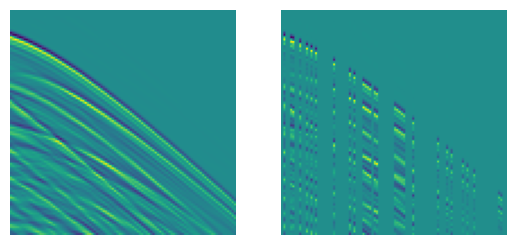

In [74]:

# ---------- LOAD Image ---------------------------
folder = "./dependencies/measurementData"
file = room+"RIR.mat"
file_path = os.path.join(folder, file)
print("Image loaded:")
print(file_path)

# Load full image and select a subimage to apply decomposition
full_image = load_DB_ZEA(file_path)[0]
orig_image = full_image[Tstart:Tend, :N0]

mask0, _ = rand_downsamp_RIR(orig_image.shape, ratio_t=1, ratio_x=ratio_undersampling)

fig, ax = plt.subplots(1,2)
ax[0].imshow(orig_image[Tstart:Tstart+100, :])
ax[1].imshow((orig_image*mask0)[Tstart:Tstart+100, :])

ax[0].axis('off')
ax[1].axis('off')
plt.show()




## Extrapolation // Padding

(128, 128)
(1, 128)


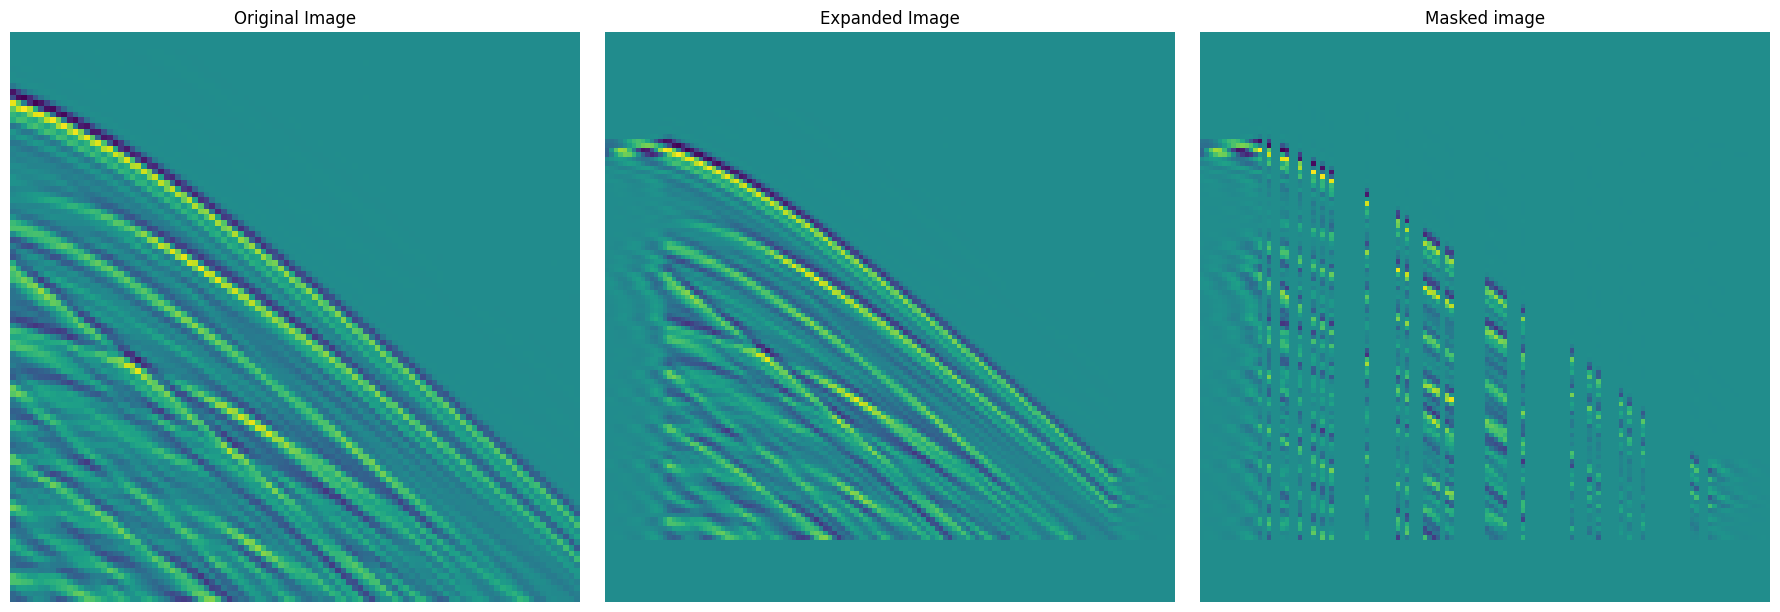

In [76]:
# ----------------------------------------------------
# Extrapolation
# ----------------------------------------------------

extr_size = Sk.shape[:2]
imOps = ImageOps(orig_image.shape, mask=mask0, extrap_shape=extr_size, mode=extrap_mode) 

image = imOps.expand_image(orig_image)
mask = imOps.get_mask(image)

print(image.shape)
print(mask.shape)

images = [orig_image, image, mask*image]
titles = ['Original Image', 'Expanded Image', 'Masked image']
fig, ax = plt.subplots(1, len(images), figsize=(18, 6))
for i in range(len(images)):
    ax[i].imshow(images[i][:128,:])
    ax[i].set_title(titles[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Proyection

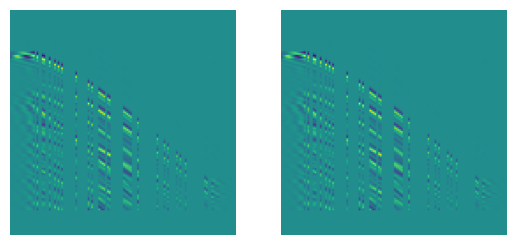

Pareto iteration 1/50.
Pareto iteration 2/50.
Pareto iteration 3/50.
Pareto iteration 4/50.
Pareto iteration 5/50.
Pareto iteration 6/50.
Pareto iteration 7/50.
Pareto iteration 8/50.
Pareto iteration 9/50.
Pareto iteration 10/50.
Pareto iteration 11/50.
Pareto iteration 12/50.
Pareto iteration 13/50.
Pareto iteration 14/50.
Pareto iteration 15/50.
Pareto iteration 16/50.
Pareto iteration 17/50.
Pareto iteration 18/50.
Pareto iteration 19/50.
Pareto iteration 20/50.
Pareto iteration 21/50.
Pareto iteration 22/50.
Pareto iteration 23/50.
Pareto iteration 24/50.
Pareto iteration 25/50.
Pareto iteration 26/50.
Pareto iteration 27/50.
Pareto iteration 28/50.
Pareto iteration 29/50.
Pareto iteration 30/50.
Pareto iteration 31/50.
Pareto iteration 32/50.
Pareto iteration 33/50.
Pareto iteration 34/50.
Pareto iteration 35/50.
Pareto iteration 36/50.
Pareto iteration 37/50.
Pareto iteration 38/50.
Pareto iteration 39/50.
Pareto iteration 40/50.
Pareto iteration 41/50.
Pareto iteration 42/50.
P

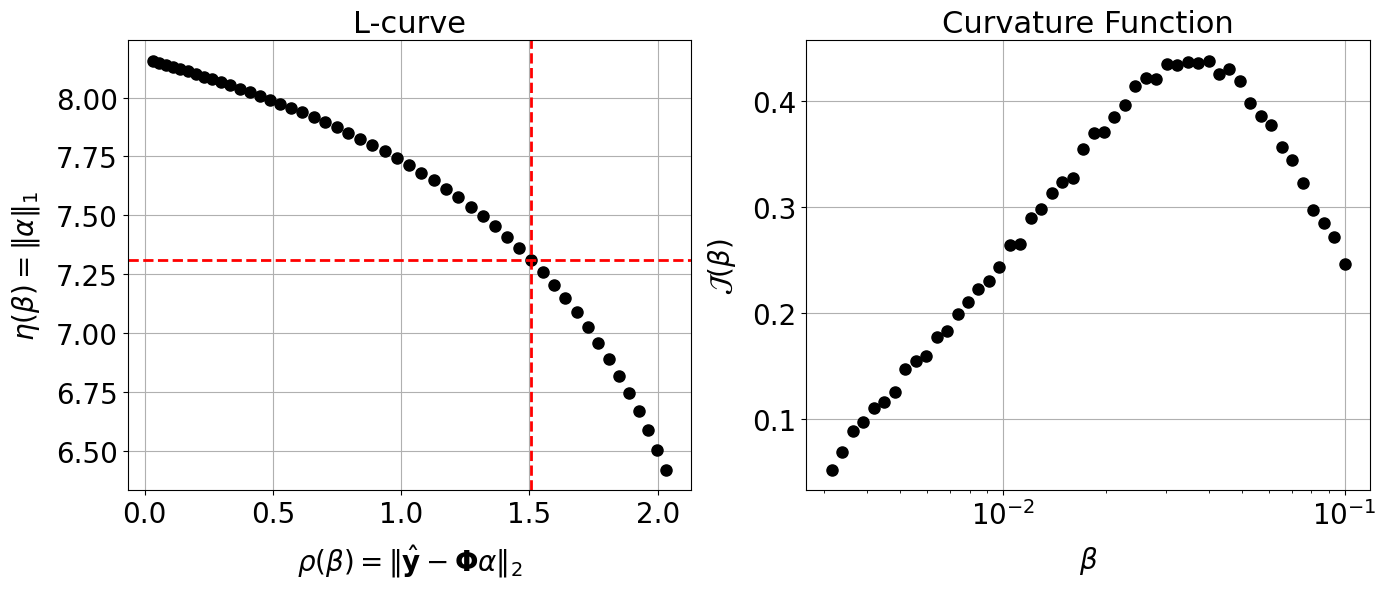

In [77]:
# ----------------------------------------------------
# Proyection
# ----------------------------------------------------
image = mask*image
alphas = ffst(image, Sk)
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(mask*image)

ax[0].axis('off')
ax[1].axis('off')
plt.show()
# ----------------------------------------------------
# Pareto
# ----------------------------------------------------

beta_set = np.logspace(-2.5, -1, 50)
beta_star, Jcurve = computePareto(image, mask, Sk, beta_set)

In [78]:

# ----------------------------------------------------
# ISTA recovery
# ----------------------------------------------------
epsilon = 9.4e-6
alpha = ista(image, mask, Sk, beta=beta_star, epsilon=epsilon, max_iterations=15 )



Iteration no. 1/15, res_norm: 4.3063306513075394
Iteration no. 2/15, res_norm: 3.969501869105772
Iteration no. 3/15, res_norm: 3.5971201983197862
Iteration no. 4/15, res_norm: 3.2776378220822435
Iteration no. 5/15, res_norm: 2.996351629776886
Iteration no. 6/15, res_norm: 2.7389300638004555
Iteration no. 7/15, res_norm: 2.4950663049525263
Iteration no. 8/15, res_norm: 2.2583093386536643
Iteration no. 9/15, res_norm: 2.023222070804895
Iteration no. 10/15, res_norm: 1.7845543168307811
Iteration no. 11/15, res_norm: 1.536964537317394
Iteration no. 12/15, res_norm: 1.2727881177311824
Iteration no. 13/15, res_norm: 0.9794835969258084
Iteration no. 14/15, res_norm: 0.6332902245060358
Iteration no. 15/15, res_norm: 0.18671055115395932
Interpolating image from thresholded coefficients...

---------------- INTERPOLATION DONE! ----------------



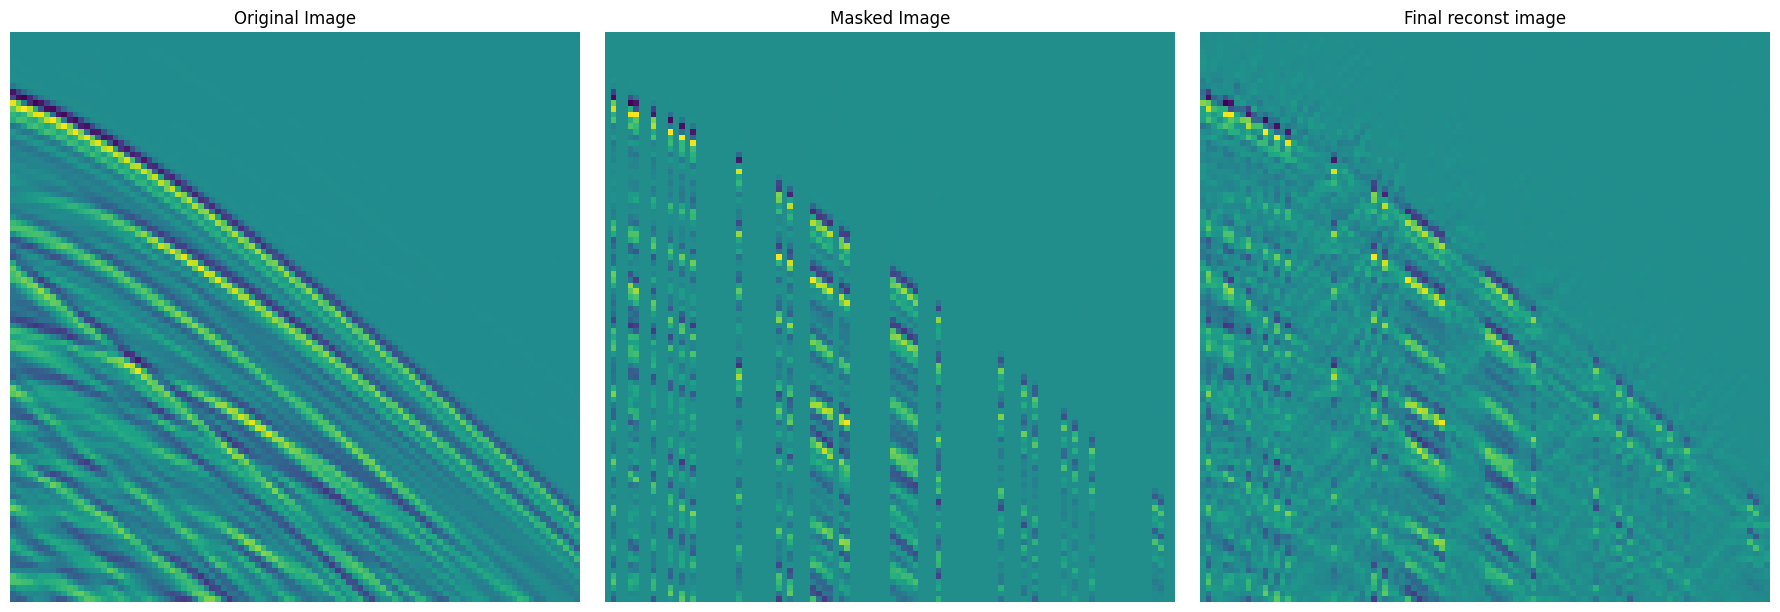

In [79]:
# recover inpainted image from sparse coefficients (Eq. 19)
image_recov = iffst(alpha, Sk)
final_image = imOps.recover_image(image_recov)

images = [orig_image[:100,:], (orig_image*mask0)[:100,:], final_image[:100,:]]
titles = ['Original Image', 'Masked Image', 'Final reconst image']
fig, ax = plt.subplots(1, len(images), figsize=(18, 6))
for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[i].set_title(titles[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()